In [13]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt
import copy
import itertools

In [14]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [15]:
def select_significant_areas(df, threshold=0.05):
    tests = ['pval_Control_vs_Fam', 'pval_Control_vs_Unfam', 'pval_Fam_vs_Unfam']
    d = []
    for key in tests:
        d.append(df.sort_values(by=key)[[
        'area', key]]['area'][df.sort_values(by=key)[[
        'area', key]][key] < threshold].to_list())
    # return flattened list
    return list(itertools.chain.from_iterable(d))

In [16]:
def plot_graph(corr_matrix, title, ax, significant_areas=None, corr_threshold=0.85):
    df_graph = corr_matrix.stack().reset_index(level=0)
    df_graph.columns = ['area2', 'corr']
    df_graph = df_graph.reset_index()
    df_graph.columns = ['area1', 'area2', 'corr']
    # subsample areas only if the significant areas are given
    if significant_areas is not None:
        df_graph = df_graph.loc[df_graph['area1'].isin(significant_areas)]
        df_graph = df_graph.loc[df_graph['area2'].isin(significant_areas)]
        
    # Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
    links_filtered=df_graph.loc[(df_graph['corr'] > corr_threshold) & 
                                (df_graph['area1'] != df_graph['area2']) & 
                                (df_graph['corr'] != 1)]
    # Build your graph
    G=nx.from_pandas_edgelist(links_filtered, 'area1', 'area2')
    
    # create dictionary of acronyms
    dictionary_labels = {area:volumes.loc[volumes['safe_name'] == area]['acronym'].values[0]\
                     for area in significant_areas}
    
    G = nx.relabel_nodes(G=G, mapping=dictionary_labels, copy=False)
    
    # Plot the network:
    pos = nx.circular_layout(G)
    
    nx.draw(G, with_labels=True, node_color='orange', node_size=200, edge_color='black', linewidths=1, 
            font_size=12, pos=pos, ax=ax)
    # relabel graphs
    ax.set_title(title)
    return ax

# C57 mice

In [17]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
subjects = ace.list_subjects(root_directory)
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
dict_results_across_mice = np.load('dict_results_across_mice_c57.npy', allow_pickle=True).item()

In [18]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)

In [19]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [20]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [21]:
sig_areas_ncells_ttest = select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
sig_areas_ncells_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_ncells, threshold=0.05)

In [22]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

# Graph control

## only on correlations - ncells

<AxesSubplot:title={'center':'ncells UNFAM'}>

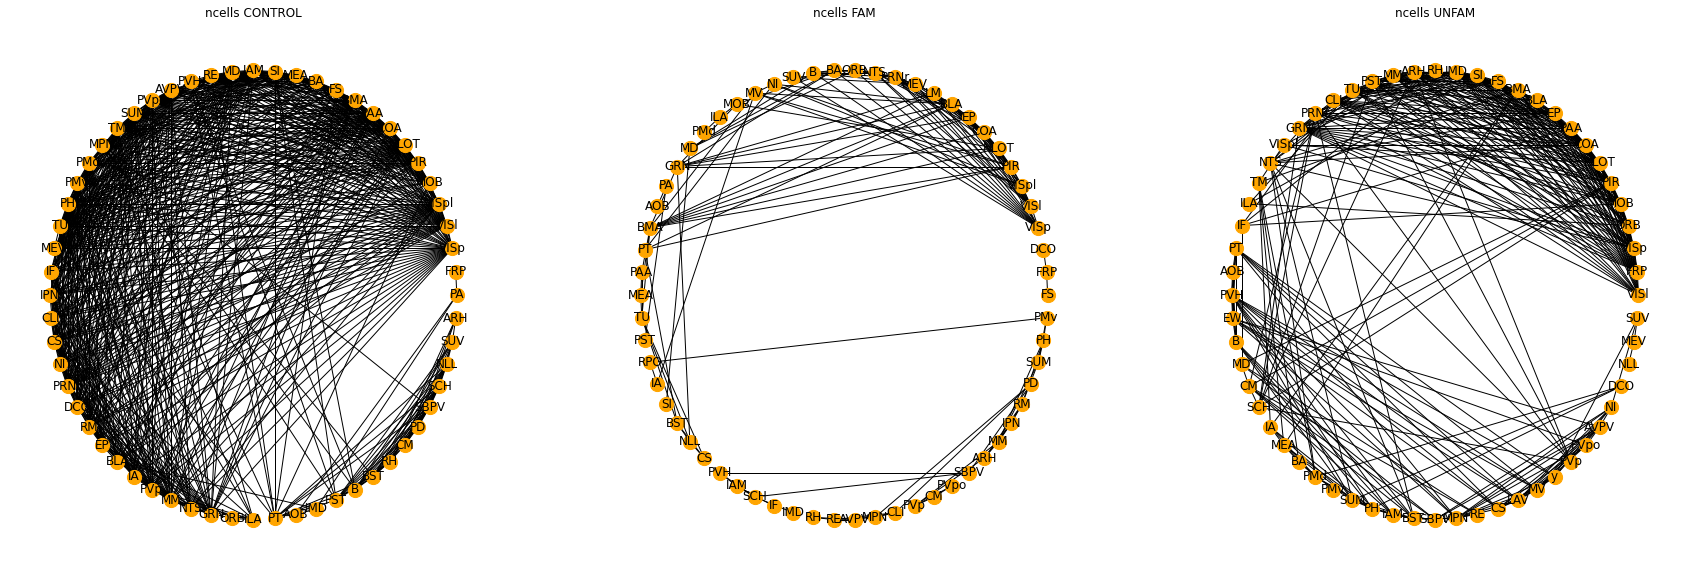

In [23]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
plot_graph(corr_matrix=corr_matrix_control_ncells, significant_areas=sig_areas_ncells_mannwhitneyu, 
           ax=axes[0], title='ncells CONTROL')
plot_graph(corr_matrix=corr_matrix_fam_ncells,  significant_areas=sig_areas_ncells_mannwhitneyu, 
           ax=axes[1], title='ncells FAM')
plot_graph(corr_matrix=corr_matrix_unfam_ncells,  significant_areas=sig_areas_ncells_mannwhitneyu, 
           ax=axes[2], title='ncells UNFAM')

## only on correlation - energy

In [24]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

In [25]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [26]:
sig_areas_energy_ttest = select_significant_areas(df=df_ttest_not_null_energy, threshold=0.05)
sig_areas_energy_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_energy, threshold=0.05)

In [27]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

<AxesSubplot:title={'center':'energy UNFAM'}>

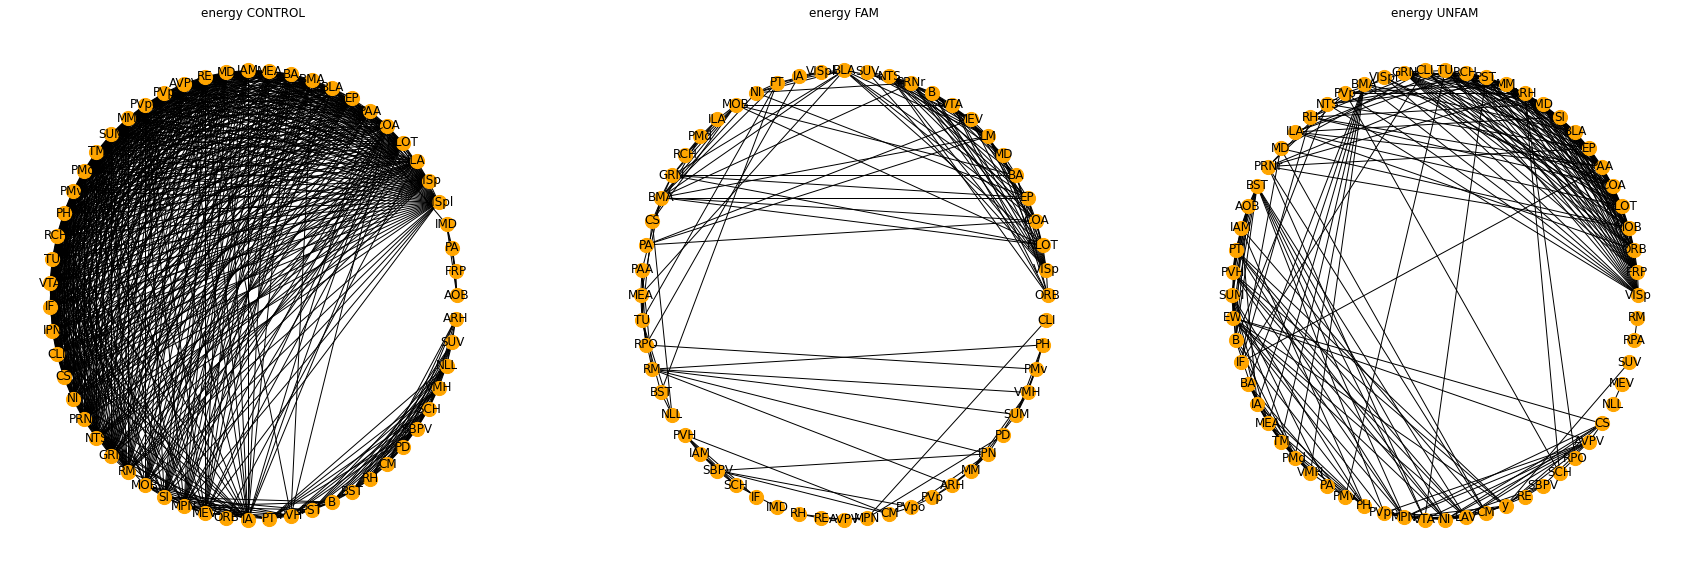

In [28]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
plot_graph(corr_matrix=corr_matrix_control_energy, significant_areas=sig_areas_energy_mannwhitneyu, 
           ax=axes[0], title='energy CONTROL')
plot_graph(corr_matrix=corr_matrix_fam_energy,  significant_areas=sig_areas_energy_mannwhitneyu, 
           ax=axes[1], title='energy FAM')
plot_graph(corr_matrix=corr_matrix_unfam_energy,  significant_areas=sig_areas_energy_mannwhitneyu, 
           ax=axes[2], title='energy UNFAM')

# SWISS 19-35

In [43]:
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]
subjects = [sub for sub in subjects if sub[0:2]=='SW' and int(sub[2:].split('_')[0]) in set(range(19,36))]
dict_results_across_mice = np.load('dict_results_across_mice_SW19-35.npy', allow_pickle=True).item()
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
sig_areas_ncells_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_ncells, threshold=0.05)
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

<AxesSubplot:title={'center':'ncells UNFAM'}>

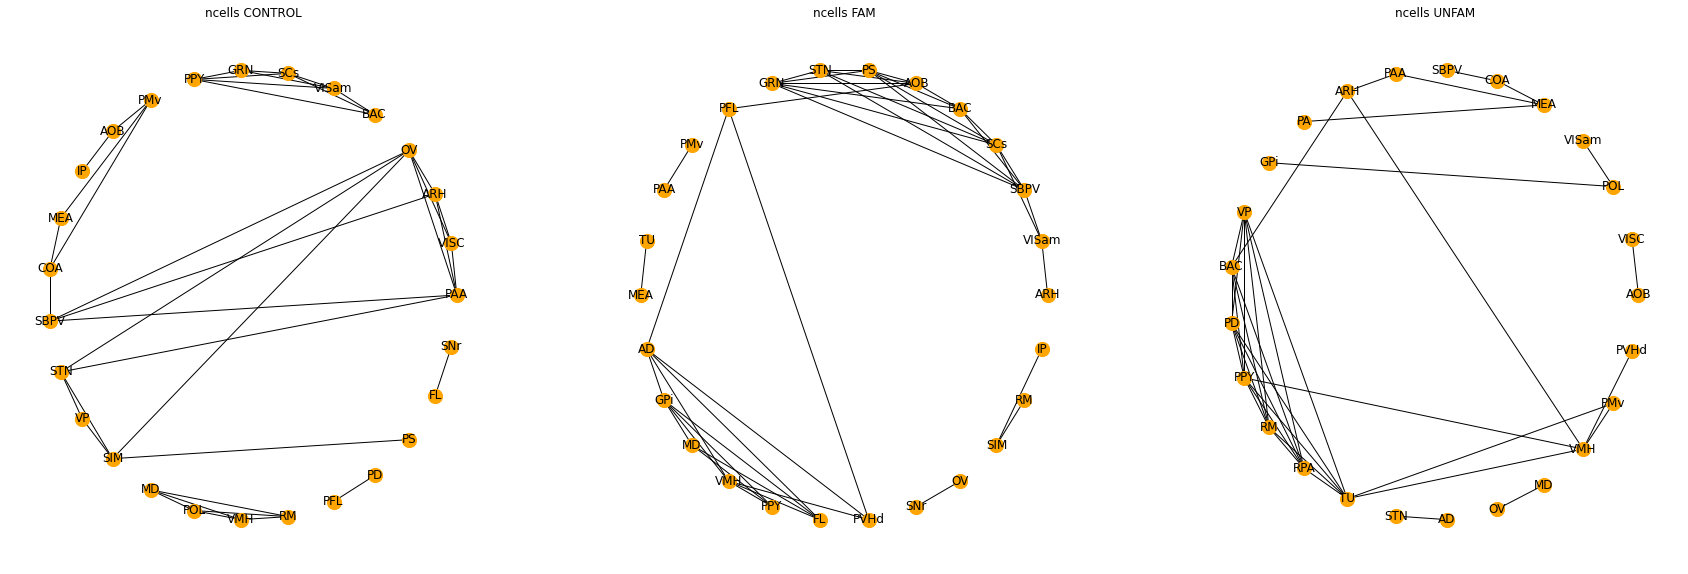

In [44]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
plot_graph(corr_matrix=corr_matrix_control_ncells, significant_areas=sig_areas_ncells_mannwhitneyu, 
           ax=axes[0], title='ncells CONTROL')
plot_graph(corr_matrix=corr_matrix_fam_ncells,  significant_areas=sig_areas_ncells_mannwhitneyu, 
           ax=axes[1], title='ncells FAM')
plot_graph(corr_matrix=corr_matrix_unfam_ncells,  significant_areas=sig_areas_ncells_mannwhitneyu, 
           ax=axes[2], title='ncells UNFAM')

In [45]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_energy_ttest = select_significant_areas(df=df_ttest_not_null_energy, threshold=0.05)
sig_areas_energy_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_energy, threshold=0.05)
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

<AxesSubplot:title={'center':'energy UNFAM'}>

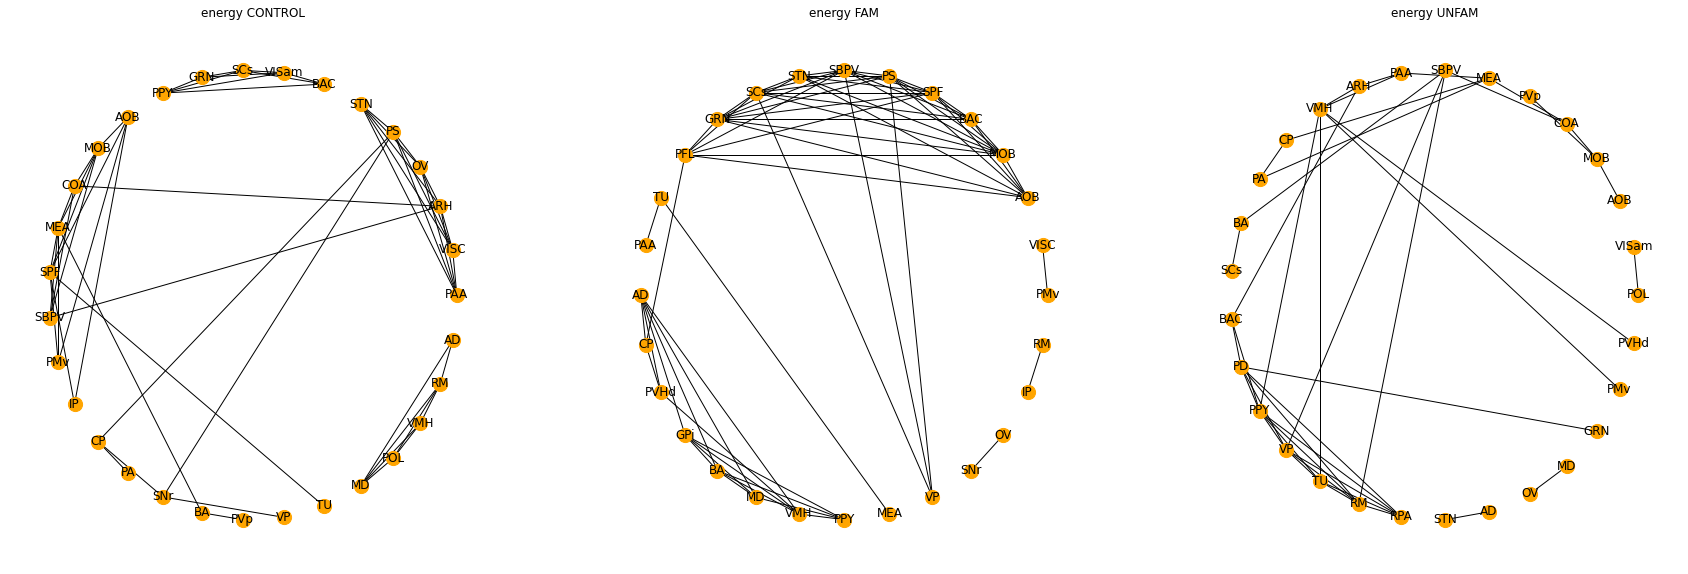

In [46]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
plot_graph(corr_matrix=corr_matrix_control_energy, significant_areas=sig_areas_energy_mannwhitneyu, 
           ax=axes[0], title='energy CONTROL')
plot_graph(corr_matrix=corr_matrix_fam_energy,  significant_areas=sig_areas_energy_mannwhitneyu, 
           ax=axes[1], title='energy FAM')
plot_graph(corr_matrix=corr_matrix_unfam_energy,  significant_areas=sig_areas_energy_mannwhitneyu, 
           ax=axes[2], title='energy UNFAM')